#### Create a Landmask with buffer

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely import wkt

In [ ]:
# User Parameters - Update these
# -------------------------------

# OpenStreetMap (osm): https://osmdata.openstreetmap.de/data/ (much more accurate than GSHHG/natural earth )
input_shapefile = '/mnt/f/ArcticDeepSeepsData/shapefiles/osm/land-polygons-split-4326/land-polygons-split-4326/land_polygons.shp'
# Coordinate Reference System (CRS) of input shapefile
input_shapefile_crs = 'EPSG:4326'  # or 'EPSG:3857'


# Define your Area of Interest (AOI) using a WKT polygon to subset the original shapefile

# Scott Trough area
# aoi_wkt = "POLYGON((-71.495 71.0, -68.7 71.0, -68.7 72, -71.495 72, -71.495 71.0))" 

# Baffin Bay partially: Scott Trough and Disko Bay
# aoi_wkt = "POLYGON((-74.433 71.6112,-67.5236 68.7391,-52.6642 65.1631,-49.3945 68.8984,-50.6281 71.1092,-72.7283 72.2781,-74.433 71.6112))"

# Greenland, Svalbard and Canadian Arctic 
# aoi_wkt = "POLYGON((-57.5243 62.8078,-47.0583 57.8763,-37.7048 58.2295,-27.0111 66.9488,-4.6268 72.3274,28.8078 75.8499,36.6274 81.339,-29.2672 86.7018,-126.7371 76.6394,-129.6882 72.0057,-115.6035 68.5418,-98.6488 68.3438,-78.1484 66.7115,-78.9566 64.0555,-72.767 62.547,-66.559 60.7115,-57.5243 62.8078))"

# Pituffik airbase area
# aoi_wkt = "POLYGON((-73.2502 75.6276,-64.6877 75.6276,-64.6877 77.4513,-73.2502 77.4513,-73.2502 75.6276))"

# Svalbard 
# aoi_wkt = "POLYGON((4.0188 79.2857,18.8145 73.7779,38.8007 80.4791,21.1413 81.2552,4.0188 79.2857))"

# Disko Bay
aoi_wkt = "POLYGON((-55.0784 68.431,-50.5926 68.431,-50.5926 69.6951,-55.0784 69.6951,-55.0784 68.431))"



# Specify the UTM CRS of the AOI 
# geotiff_crs = 'EPSG:32633'  # UTM Zone 33N (svalbard)
# geotiff_crs = 'EPSG:32619'  # UTM Zone 19N (Scott Trough/Baffin Island)
geotiff_crs = 'EPSG:32621'  # UTM Zone 21N (Disko Bay/Western Greenland)


# Pixel size in meters: adjust based on your GeoTIFF resolution
pixel_size = 40 
# Desired buffer size in number of pixels
buffer_pixels = 8


# Create folder for output shapefile
output_dir = '/home/mtontsch/DeepSeepNet/data/shapefiles'
foldername_new = 'osm_buffered_diskobay'
if not os.path.exists(f'{output_dir}/{foldername_new}/'):
    os.makedirs(f'{output_dir}/{foldername_new}/')

# Output path for the new shapefile with a shoreline buffer
filename_old = 'osm_land_polygons'
filename_new = f'{filename_old}_buffered_{pixel_size}m_{buffer_pixels}px'
output_shapefile = f'{output_dir}/{foldername_new}/{filename_new}.shp'



In [3]:
# Shapefile Buffering 
# -------------------------------

def directional_buffer(geom, dist):
    """
    - If this is a LineString / MultiLineString: do a single-sided buffer
      (you get a Polygon strip on one side).
    - If this is a Polygon / MultiPolygon: do a normal buffer (expands outward).
    """
    t = geom.geom_type
    if t in ("LineString", "MultiLineString"):
        # single_sided=True only makes sense on linear geometries
        return geom.buffer(dist, single_sided=True)
    elif t in ("Polygon", "MultiPolygon"):
        # standard outward buffer on a polygon
        return geom.buffer(dist)
    else:
        # catch–all: just do a normal buffer
        return geom.buffer(dist)


# Calculate buffer distance in meters
buffer_distance = pixel_size * buffer_pixels
print(f"Buffer distance: {buffer_distance} meters")

# Create a GeoDataFrame for the AOI from the WKT polygon
aoi_geometry = wkt.loads(aoi_wkt)
aoi = gpd.GeoDataFrame({'geometry': [aoi_geometry]}, crs=input_shapefile_crs)

# Reproject AOI to the shapefile's CRS if necessary
if aoi.crs != input_shapefile_crs:
    print(f"Reprojecting AOI from {aoi.crs} to {input_shapefile_crs}...")
    aoi = aoi.to_crs(input_shapefile_crs)

print("Loading the large OSM shoreline shapefile...")
# Read the large OSM shoreline shapefile
gdf = gpd.read_file(input_shapefile)

# Ensure the CRS matches; reproject if necessary
if gdf.crs != input_shapefile_crs:
    print(f"Reprojecting shapefile from {gdf.crs} to {input_shapefile_crs}...")
    gdf = gdf.to_crs(input_shapefile_crs)

print("Clipping the shoreline shapefile to the AOI...")
# Clip the shoreline shapefile to the AOI
gdf_clipped = gpd.clip(gdf, aoi)

# Reproject the clipped shapefile to GeoTIFF CRS for buffering
if gdf_clipped.crs != geotiff_crs:
    print(f"Reprojecting clipped shapefile from {gdf_clipped.crs} to {geotiff_crs} for buffering...")
    gdf_clipped_proj = gdf_clipped.to_crs(geotiff_crs)
else:
    gdf_clipped_proj = gdf_clipped


# Apply our buffer:
print(f"Applying a buffer of {buffer_distance} meters to the shoreline geometries...")
gdf_buffered_proj = gdf_clipped_proj.copy()
gdf_buffered_proj["geometry"] = (
    gdf_clipped_proj.geometry
    .apply(lambda g: directional_buffer(g, buffer_distance))
)

# Reproject the buffered geometries back to the original shapefile CRS
gdf_buffered = gdf_buffered_proj.to_crs(input_shapefile_crs)


# Save the result to a new shapefile
print(f"Saving the smaller buffered shapefile to {output_shapefile}...")
gdf_buffered.to_file(output_shapefile)

print("Shapefile generation complete!")

Buffer distance: 320 meters
Loading the large OSM shoreline shapefile...
Clipping the shoreline shapefile to the AOI...
Reprojecting clipped shapefile from EPSG:4326 to EPSG:32621 for buffering...
Applying a buffer of 320 meters to the shoreline geometries...
Saving the smaller buffered shapefile to /home/mtontsch/DeepSeepNet/data/shapefiles/osm_buffered_diskobay/osm_land_polygons_buffered_40m_8px.shp...
Shapefile generation complete!


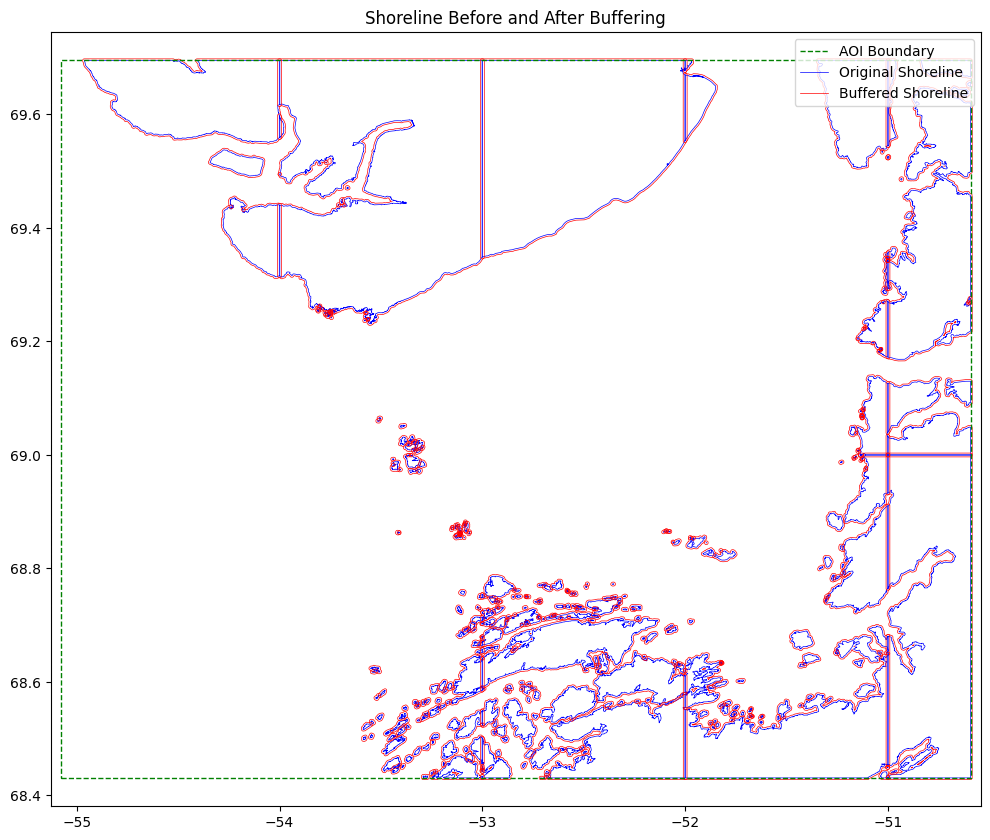

In [5]:
# Plot difference between original and buffered shoreline
# -------------------------------

# Create a GeoDataFrame for the AOI from the WKT polygon
aoi_geometry = wkt.loads(aoi_wkt)
aoi = gpd.GeoDataFrame({'geometry': [aoi_geometry]}, crs=input_shapefile_crs)

# Load the buffered shoreline shapefile
gdf_buffered = gpd.read_file(output_shapefile)

# Load the original shoreline shapefile
gdf_original = gpd.read_file(input_shapefile)

# Ensure the CRS matches; reproject if necessary
if gdf_original.crs != input_shapefile_crs:
    gdf_original = gdf_original.to_crs(input_shapefile_crs)
if gdf_buffered.crs != input_shapefile_crs:
    gdf_buffered = gdf_buffered.to_crs(input_shapefile_crs)

# Clip the original shoreline to the AOI
gdf_original_clipped = gpd.clip(gdf_original, aoi)

# Create the plot
fig, ax = plt.subplots(figsize=(12,12))

# 1) AOI boundary
aoi.boundary.plot(
    ax=ax,
    color='green',
    linestyle='--',
    linewidth=1,
    label='AOI Boundary'
)

# 2) Original shoreline
gdf_original_clipped.plot(
    ax=ax,
    linewidth=0.5,
    facecolor='none',
    edgecolor='blue',
    label='Original Shoreline'
)

# 3) Buffered shoreline
gdf_buffered.plot(
    ax=ax,
    facecolor='none',
    edgecolor='red',
    linewidth=0.5,
    label='Buffered Shoreline'
)

# Set extent
lat_margin = 0.05
lon_margin = 0.05
ax.set_xlim(aoi.bounds.minx.min() - lon_margin, aoi.bounds.maxx.max() + lon_margin)
ax.set_ylim(aoi.bounds.miny.min() - lat_margin, aoi.bounds.maxy.max() + lat_margin)

ax.set_title('Shoreline Before and After Buffering')


proxy_aoi   = Line2D([0], [0], color='green', linestyle='--', linewidth=1, label='AOI Boundary')
proxy_orig  = Line2D([0], [0], color='blue', linewidth=0.5, label='Original Shoreline')
proxy_buf   = Line2D([0], [0], color='red', linewidth=0.5, label='Buffered Shoreline')

# ... after plotting everything ...

ax.legend(handles=[proxy_aoi, proxy_orig, proxy_buf], loc='upper right')


plt.show()


In [ ]:
def plot_shapefile(shapefile_path):
    if not os.path.isfile(shapefile_path):
        raise FileNotFoundError(f"No such file: {shapefile_path}")
    gdf = gpd.read_file(shapefile_path)

    fig, ax = plt.subplots(figsize=(8, 8))
    gdf.plot(ax=ax, edgecolor='black', facecolor='none')
    ax.set_title(f"Shapefile: {os.path.basename(shapefile_path)}")
    ax.set_axis_off()   # hides axes ticks/frame if you like
    plt.tight_layout()
    plt.show()


path = '/home/mtontsch/DeepSeepNet/data/shapefiles/osm_buffered_baffin/osm_land_polygons_buffered_40m_50px.shp'
plot_shapefile(path)